### Cell 1: Import required libraries

In [1]:
# Data handling
import pandas as pd
import numpy as np

# Data preprocessing and modeling
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_auc_score

# XGBoost
from xgboost import XGBClassifier

# Utilities
import joblib
import os
import matplotlib.pyplot as plt
import seaborn as sns

### Cell 2: Load and prepare data

In [2]:
# Load filtered gene expression dataset
df = pd.read_csv("../data/selected_expression_data.csv")

# Separate features and target
X = df.drop(columns=["label"])
y = df["label"]

# Train-test split with stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, stratify=y, random_state=42
)

# Standardize features
scaler_xgb = StandardScaler()
X_train_scaled = scaler_xgb.fit_transform(X_train)
X_test_scaled = scaler_xgb.transform(X_test)

### Cell 3: Define helper function for evaluation

In [3]:
# Define a helper function to compute key performance metrics
def get_metrics(y_true, y_pred, y_probs):
    return {
        "Accuracy": accuracy_score(y_true, y_pred),
        "F1": f1_score(y_true, y_pred, zero_division=0),
        "Precision": precision_score(y_true, y_pred, zero_division=0),
        "Recall": recall_score(y_true, y_pred, zero_division=0),
        "ROC AUC": roc_auc_score(y_true, y_probs)
    }

### Cell 4: Train baseline `XGBoost` model

In [4]:
# Train a baseline `XGBoost` model without tuning
xgb_baseline = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
xgb_baseline.fit(X_train_scaled, y_train)

# Evaluate baseline model
y_pred_xgb = xgb_baseline.predict(X_test_scaled)
y_prob_xgb = xgb_baseline.predict_proba(X_test_scaled)[:, 1]
metrics_xgb = get_metrics(y_test, y_pred_xgb, y_prob_xgb)

# Display baseline metrics
for k, v in metrics_xgb.items():
    print(f"{k}: {v:.3f}")

Accuracy: 0.764
F1: 0.190
Precision: 0.500
Recall: 0.118
ROC AUC: 0.760


C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:01:59] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Cell 5: Hyperparameter tuning with `RandomizedSearchCV`

In [5]:
# Define hyperparameter grid with imbalance handling
param_dist = {
    'n_estimators': [100, 200, 300, 500],
    'max_depth': [3, 5, 7, 10, 15],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5],                          # Minimum loss reduction
    'reg_alpha': [0, 0.1, 0.5],                  # L1 regularization
    'reg_lambda': [0.5, 1.0, 2.0],               # L2 regularization
    'scale_pos_weight': [1, 5, 10, 20]           # For imbalanced classes
}

# Initialize XGBoost classifier
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform randomized search
search_xgb = RandomizedSearchCV(
    xgb_model, param_distributions=param_dist,
    n_iter=40, scoring='f1', cv=3, n_jobs=-1, verbose=1, random_state=42
)
search_xgb.fit(X_train_scaled, y_train)

# Evaluate tuned model
y_pred_xgb_tuned = search_xgb.best_estimator_.predict(X_test_scaled)
y_prob_xgb_tuned = search_xgb.best_estimator_.predict_proba(X_test_scaled)[:, 1]
metrics_xgb_tuned = get_metrics(y_test, y_pred_xgb_tuned, y_prob_xgb_tuned)

# Display tuned model metrics
print("\nTuned XGBoost Metrics:")
for k, v in metrics_xgb_tuned.items():
    print(f"{k}: {v:.3f}")

Fitting 3 folds for each of 40 candidates, totalling 120 fits

Tuned XGBoost Metrics:
Accuracy: 0.667
F1: 0.368
Precision: 0.333
Recall: 0.412
ROC AUC: 0.735


C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:02:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Cell 7: Summary of model performance

In [6]:
# Organize metrics for comparison
metrics_summary = pd.DataFrame({
    "Baseline XGBoost": metrics_xgb,
    "Tuned XGBoost": metrics_xgb_tuned
}).T.round(3)

print("\nXGBoost Model Evaluation Summary:")
display(metrics_summary)


XGBoost Model Evaluation Summary:


,Accuracy,F1,Precision,Recall,ROC AUC
Baseline XGBoost,0.764,0.190,0.500,0.118,0.760
Tuned XGBoost,0.667,0.368,0.333,0.412,0.735


### Cell 8: Visualize model performance

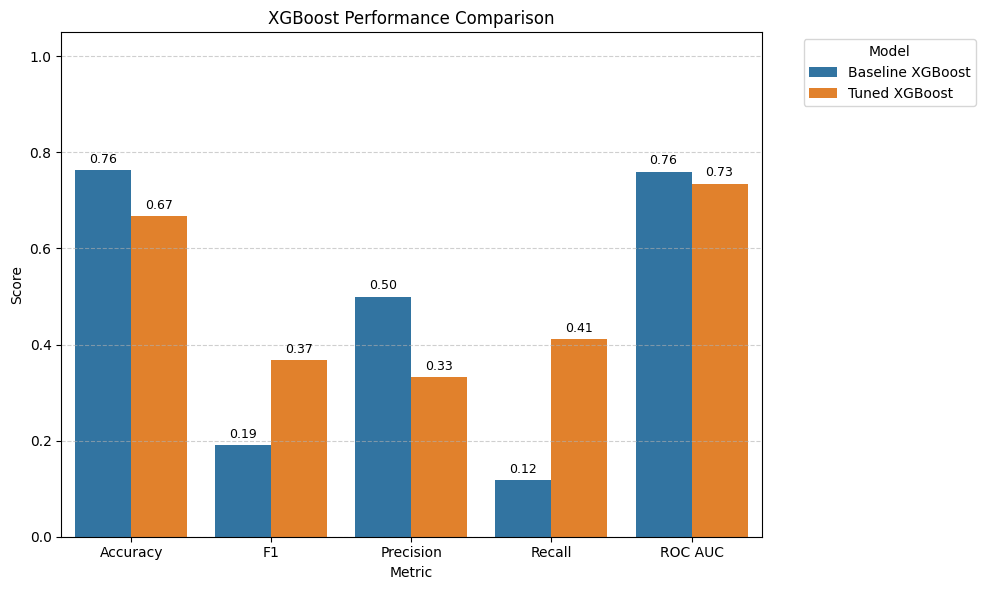

In [7]:
# Convert summary to long format
metrics_long = metrics_summary.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_long.rename(columns={'index': 'Model'}, inplace=True)

# Create bar plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_long, x='Metric', y='Score', hue='Model')

plt.title("XGBoost Performance Comparison")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate values
for p in ax.patches:
    height = p.get_height()
    if np.isnan(height) or height == 0:
        continue
    ax.annotate(f'{height:.2f}', 
                (p.get_x() + p.get_width() / 2., height), 
                ha='center', va='bottom', 
                fontsize=9, color='black', 
                xytext=(0, 3), textcoords='offset points')


plt.tight_layout()
plt.show()

### Cell 9: `XGBoost` with `scale_pos_weight`

In [8]:
# Calculate scale_pos_weight
pos_count = sum(y_train == 1)
neg_count = sum(y_train == 0)
scale_pos_weight = neg_count / pos_count

# Initialize and train XGBoost with scale_pos_weight
xgb_weighted = XGBClassifier(
    use_label_encoder=False,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight,
    random_state=42
)
xgb_weighted.fit(X_train_scaled, y_train)

# Evaluate weighted XGBoost model
y_pred_xgb_weighted = xgb_weighted.predict(X_test_scaled)
y_prob_xgb_weighted = xgb_weighted.predict_proba(X_test_scaled)[:, 1]
metrics_xgb_weighted = get_metrics(y_test, y_pred_xgb_weighted, y_prob_xgb_weighted)

# Print metrics
print("XGBoost (scale_pos_weight) Metrics:")
for k, v in metrics_xgb_weighted.items():
    print(f"{k}: {v:.3f}")

C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:02:03] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


XGBoost (scale_pos_weight) Metrics:
Accuracy: 0.819
F1: 0.435
Precision: 0.833
Recall: 0.294
ROC AUC: 0.751


### Cell 10: `XGBoost` with `scale_pos_weight` hyperparameter tuning with `scale_pos_weight`

In [9]:
# Hyperparameter tuning with scale_pos_weight
scale_pos = (y_train == 0).sum() / (y_train == 1).sum()

# Update hyperparameter grid to include scale_pos_weight
param_dist_weighted = {
    'n_estimators': [50, 100, 200, 300],
    'max_depth': [3, 5, 7, 10],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'subsample': [0.5, 0.7, 1.0],
    'colsample_bytree': [0.5, 0.7, 1.0],
    'scale_pos_weight': [scale_pos, scale_pos * 1.5, scale_pos * 2.0]
}

# Initialize XGBoost model
xgb_weighted_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)

# Perform randomized search
search_weighted = RandomizedSearchCV(
    xgb_weighted_model,
    param_distributions=param_dist_weighted,
    n_iter=20,
    scoring='f1',
    cv=3,
    n_jobs=-1,
    verbose=1,
    random_state=42
)
search_weighted.fit(X_train_scaled, y_train)

# Predict and evaluate
y_pred_xgb_weighted = search_weighted.best_estimator_.predict(X_test_scaled)
y_prob_xgb_weighted = search_weighted.best_estimator_.predict_proba(X_test_scaled)[:, 1]
metrics_xgb_weighted_tuned = get_metrics(y_test, y_pred_xgb_weighted, y_prob_xgb_weighted)

print("\nTuned XGBoost (scale_pos_weight) Metrics:")
for k, v in metrics_xgb_weighted_tuned.items():
    print(f"{k}: {v:.3f}")


Fitting 3 folds for each of 20 candidates, totalling 60 fits

Tuned XGBoost (scale_pos_weight) Metrics:
Accuracy: 0.625
F1: 0.471
Precision: 0.353
Recall: 0.706
ROC AUC: 0.658


C:\Users\chhua\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\xgboost\training.py:183: UserWarning: [20:02:04] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


### Cell 11: Include weighted `XGBoost` and weighted `XGBoost` with `RandomizedSearchCV` in summary table

In [10]:
# Updated metrics summary with 4 models
metrics_summary = pd.DataFrame({
    "Baseline XGBoost": metrics_xgb,
    "Tuned XGBoost": metrics_xgb_tuned,
    "XGBoost (scale_pos_weight)": metrics_xgb_weighted,
    "Tuned XGBoost (scale_pos_weight)": metrics_xgb_weighted_tuned
}).T.round(3)

print("\nXGBoost Model Evaluation Summary:")
display(metrics_summary)


XGBoost Model Evaluation Summary:


,Accuracy,F1,Precision,Recall,ROC AUC
Baseline XGBoost,0.764,0.190,0.500,0.118,0.760
Tuned XGBoost,0.667,0.368,0.333,0.412,0.735
XGBoost (scale_pos_weight),0.819,0.435,0.833,0.294,0.751
Tuned XGBoost (scale_pos_weight),0.625,0.471,0.353,0.706,0.658


### Model Evaluation Summary
This notebook implemented and evaluated several XGBoost classifiers to address the class imbalance present in the gene expression dataset that has been identified previously. Four configurations were tested:
1. Baseline XGBoost
2. Tuned XGBoost using `RandomizedSearchCV`
3. XGBoost with `scale_pos_weight` adjustment
4. Tuned XGBoost with `scale_pos_weight` + `RandomizedSearchCV`

Each model was evaluated using five standard metrics: Accuracy, F1 Score, Precision, Recall, and ROC AUC.

Among the models, XGBoost with `scale_pos_weight` achieved the highest accuracy (0.82) and precision (0.83), showing strong performance in predicting the majority class. Meanwhile, the tuned XGBoost with `scale_pos_weight` produced the highest recall (0.71), demonstrating improved sensitivity to detecting relapse cases.

However, despite these improvements, F1 scores remained moderate across all XGBoost configurations, indicating continued trade-offs between precision and recall.

When compared with the Random Forest models from Notebook 3, the results show:
- Random Forest (class-weighted) offered a more balanced performance, with higher F1 Score and Recall than most XGBoost variants.
- XGBoost models showed stronger performance in either precision or recall, but not both simultaneously.

These findings suggest that XGBoost can improve class-specific performance, particularly when tuning `scale_pos_weight`, but Random Forest remains the more consistent and balanced model across all metrics in this dataset.

The bar plot below illustrates the comparative performance across all four XGBoost models:
- Baseline
- Tuned
- With `scale_pos_weight`
- Tuned with `scale_pos_weight`

### Cell 11: Plot comparison for all 4 models

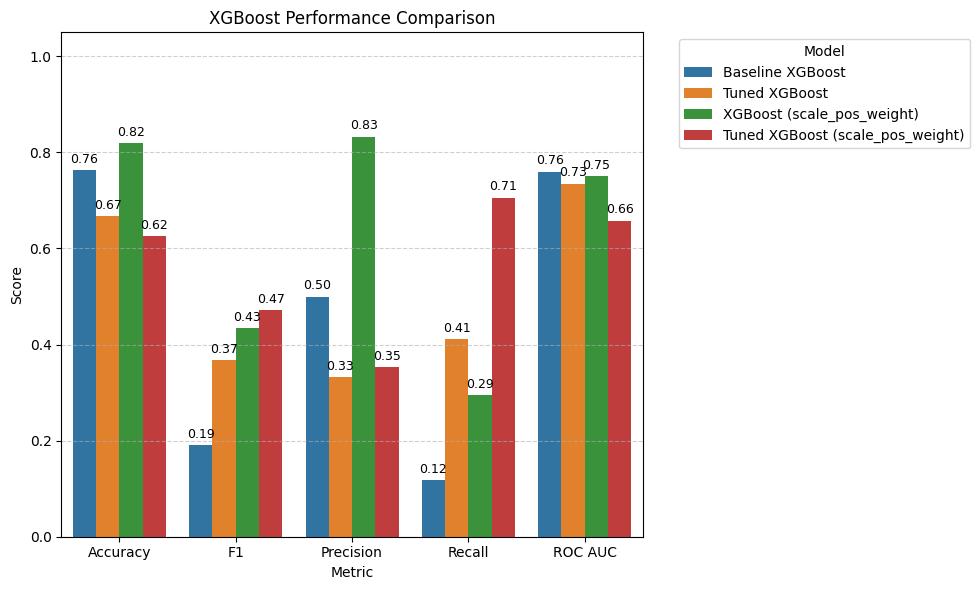

In [11]:
# Update plot to include third model
metrics_long = metrics_summary.reset_index().melt(id_vars='index', var_name='Metric', value_name='Score')
metrics_long.rename(columns={'index': 'Model'}, inplace=True)

# Plot
plt.figure(figsize=(10, 6))
ax = sns.barplot(data=metrics_long, x='Metric', y='Score', hue='Model')

plt.title("XGBoost Performance Comparison")
plt.ylim(0, 1.05)
plt.ylabel("Score")
plt.xlabel("Metric")
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.legend(title="Model", bbox_to_anchor=(1.05, 1), loc='upper left')

# Annotate bar values
for p in ax.patches:
    height = p.get_height()
    if not np.isnan(height) and height != 0:
        ax.annotate(f'{height:.2f}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', fontsize=9, color='black',
                    xytext=(0, 3), textcoords='offset points')

plt.tight_layout()
plt.show()

### Cell 12: Save model and scaler

In [12]:
# Create output directory if not exists
os.makedirs("../models", exist_ok=True)
os.makedirs('../scalers', exist_ok=True)

# # Save all three XGBoost models
joblib.dump(xgb_baseline, "../models/xgb_baseline_model.pkl")
joblib.dump(search_xgb.best_estimator_, "../models/xgb_randomsearch_model.pkl")
joblib.dump(xgb_weighted, "../models/xgb_weighted_model.pkl")
joblib.dump(search_weighted.best_estimator_, "../models/xgb_weighted_randomsearch_model.pkl")

# Save the scaler used for all models
joblib.dump(scaler_xgb, "../scalers/xgb_scaler.pkl")

print("All models have been saved to `models` and all scalers have been saved to `scalers`.")

All models have been saved to `models` and all scalers have been saved to `scalers`.


### 

### 

### 

### 

### 

### 

### 